# Análise de Corvengência de Municípios
## Daniel N. Rocha, Rafael Kovashikawa, Matheus Roman e Chen Zi
### Trabalho de Estatística – FGV EPGE
O objetivo deste estudo é realizar testes estatísticos com dados empíricos do IBGE para testar a hipótese de corvergência acerca da evolução do PIB dos municípios brasileiros. Isto é, testaremos se os municípios com economia menor de fato cresceram mais rapidamente do que os que possuiam atividade econômica mais intensa.

Embora haja disponibilidade de dados a partir 1999, utilizamos o ano de 2002 como período inicial, tendo em vista que houve mudança metodológica na coleta e agregação dos dados entre os anos de 1999 e 2002. Segundo o IBGE: 

"_Para os anos anteriores a 2010, cabe ressaltar, realizou-se a retropolação dos dados até 2002, considerando-se a disponibilidade de informações para o período, e estimou-se uma nova série, adaptada às alterações da CNAE 2.0. [Classificação Nacional de Atividades Econômicas - CNAE 2.0.]_"

A série temporal termina em 2017 pois é o último ano de dados disponibilizados pelo IBGE. Dentro do recorte temporal selecionado é possível garantir que os dados são comparáveis entre si e "estão completamente integrados às séries das Contas Nacionais e das Contas Regionais do Brasil".

In [1]:
%%capture
%pip install xlrd
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install palettable
%pip install matplotlib
%pip install jupyterthemes

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
import numpy as np
import seaborn as sns
import palettable
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [3]:
import matplotlib.style
import matplotlib as mpl
for m,n in zip(['grid.color','axes.titlecolor','axes.labelcolor','xtick.color','ytick.color',
                'axes.titlesize','figure.figsize','legend.framealpha'],['white','white','white',
                'white','white','20.0','13.0, 8.0','0.8']):
    mpl.rcParams[m] = n

## 1. Importando os Dados:
Todos os dados foram coletados do site do IBGE e podem ser consultados no seguinte link: https://www.ibge.gov.br/estatisticas/economicas/contas-nacionais/9088-produto-interno-bruto-dos-municipios.html

In [4]:
pib_cities_02_09 = pd.read_excel('PIB dos Municipios - base de dados 2002-2009.xls')
pib_cities_10_17 = pd.read_excel('PIB dos Municipios - base de dados 2010-2017.xls')

In [5]:
pib_cities = pd.concat([pib_cities_02_09, pib_cities_10_17], ignore_index=True).copy()

In [6]:
pib_cities = pib_cities[['Ano','Nome da Grande Região','Nome da Unidade da Federação','Nome do Município',
                         'Código do Município','Produto Interno Bruto per capita, \na preços correntes\n(R$ 1,00)',
                         'Valor adicionado bruto total, \na preços correntes\n(R$ 1.000)',
                         'Produto Interno Bruto, \na preços correntes\n(R$ 1.000)']]
pib_cities.rename(inplace=True, columns={'Produto Interno Bruto, \na preços correntes\n(R$ 1.000)':'PIB',
                              'Valor adicionado bruto total, \na preços correntes\n(R$ 1.000)':'Valor adicionado',
                              'Produto Interno Bruto per capita, \na preços correntes\n(R$ 1,00)':'PIB per capita',
                              'Nome da Grande Região':'Região','Nome da Unidade da Federação':'UF',
                              'Nome do Município':'Município'})
pib_cities

,Ano,Região,UF,Município,Código do Município,PIB per capita,Valor adicionado,PIB
0,2002,Norte,Rondônia,Alta Floresta D'Oeste,1100015,4047.83,103741.73,111290.99
1,2002,Norte,Rondônia,Ariquemes,1100023,5667.37,406926.84,449592.82
2,2002,Norte,Rondônia,Cabixi,1100031,4246.99,29899.58,31767.52
3,2002,Norte,Rondônia,Cacoal,1100049,6353.27,424820.15,474443.10
4,2002,Norte,Rondônia,Cerejeiras,1100056,4442.47,70972.64,79173.61
...,...,...,...,...,...,...,...,...
89041,2017,Centro-oeste,Goiás,Vianópolis,5222005,28942.36,367357.48,395786.81
89042,2017,Centro-oeste,Goiás,Vicentinópolis,5222054,41772.71,331192.92,350765.42
89043,2017,Centro-oeste,Goiás,Vila Boa,5222203,23992.38,112890.80,137500.32
89044,2017,Centro-oeste,Goiás,Vila Propício,5222302,32016.61,176298.36,182174.52


In [7]:
codigos_cidades = pib_cities[['Município','Código do Município']].drop_duplicates()
# salvando a tabela para retirar a coluna de codigo de municipio da analise sem perdas de dados

In [8]:
AMCs_dict = {'Figueirão': 'Camapuã', 'Costa Rica': 'Camapuã', 'Paraíso das Águas': 'Camapuã', 'Água Clara': 'Camapuã',  # Camapuã
             'Ipiranga do Norte': 'Tapurah','Itanhangá': 'Tapurah',                                                     # Tapurah
             'Mojuí dos Campos': 'Santarém',                                                                            # Santarém
             'Aroeiras do Itaim': 'Picos',                                                                              # Picos
             'Nazária': 'Teresina',                                                                                     # Teresina
             'Pescaria Brava': 'Laguna',                                                                                # Laguna
             'Balneário Rincão': 'Içara',                                                                               # Içara
             'Pinto Bandeira': 'Bento Gonçalves'}                                                                       # Bento Gonçalves
tratamento_AMCs = pib_cities['Município'].map(AMCs_dict).fillna(pib_cities['Município'])
pib_cities['Município'] = tratamento_AMCs

In [9]:
pib_cities['População'] = pib_cities['PIB']/pib_cities['PIB per capita']
pib_cities = pib_cities.drop('Código do Município', axis=1)

In [10]:
pib_cities = pib_cities.drop('PIB per capita', axis=1)
pib_cities = pib_cities.groupby(['Ano', 'Região', 'UF', 'Município'], as_index=False).sum()
pib_cities['PIB per capita'] = pib_cities['PIB'] / pib_cities['População']
pib_cities

,Ano,Região,UF,Município,Valor adicionado,PIB,População,PIB per capita
0,2002,Centro-oeste,Distrito Federal,Brasília,46975920.59,53902199.80,2180.41,24721.18
1,2002,Centro-oeste,Goiás,Abadia de Goiás,18196.13,19813.14,5.58,3552.65
2,2002,Centro-oeste,Goiás,Abadiânia,35960.34,38866.89,12.04,3227.88
3,2002,Centro-oeste,Goiás,Acreúna,225888.33,248595.28,19.52,12736.07
4,2002,Centro-oeste,Goiás,Adelândia,7765.65,8201.22,2.50,3287.06
...,...,...,...,...,...,...,...,...
88923,2017,Sul,Santa Catarina,Zortéa,66175.80,69088.86,3.30,20936.02
88924,2017,Sul,Santa Catarina,Água Doce,277503.23,298261.42,7.15,41691.56
88925,2017,Sul,Santa Catarina,Águas Frias,83015.99,93258.91,2.39,39069.51
88926,2017,Sul,Santa Catarina,Águas Mornas,128481.50,137159.02,6.30,21778.19


### Criando colunas de variação percentual

In [11]:
pib_cities.sort_values(['Município','UF','Ano'],inplace=True,ignore_index=True)

In [12]:
pib_cities['Região']
for i in ['PIB per capita','Valor adicionado','PIB','População']:
    pib_cities['PC_'+i.split(' ')[-1]] = pib_cities.groupby(['Município','UF'])[i].apply(pd.Series.pct_change)

## 2. Plotando os Retornos:

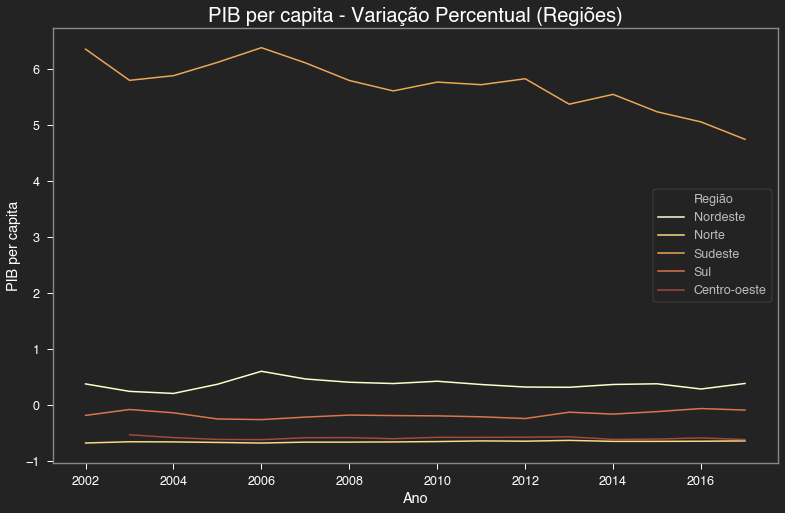

In [13]:
cmap = palettable.scientific.sequential.LaJolla_7.hex_colors[:-2]
agg=pib_cities.groupby(['Ano','Região']).sum()[['PIB per capita','Valor adicionado','PIB','População']].reset_index().copy()
data=agg[['PIB per capita','Valor adicionado','PIB','População']].pct_change().dropna().copy()
data.insert(0,'Ano',agg['Ano'])
data.insert(1,'Região',agg['Região'])
sns.lineplot(data=data,x='Ano',y='PIB per capita',hue='Região',palette=cmap)
plt.title('PIB per capita - Variação Percentual (Regiões)');

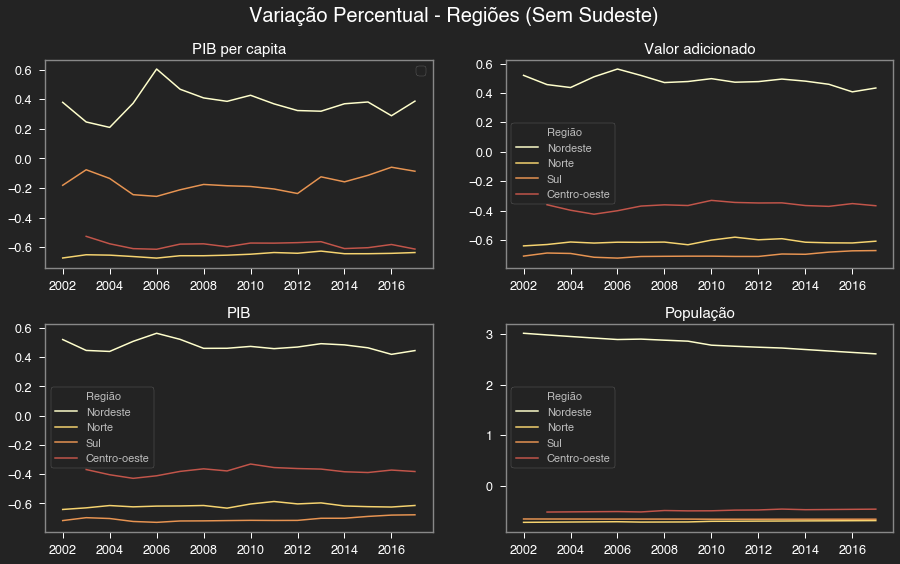

In [14]:
cmap = palettable.scientific.sequential.LaJolla_6.hex_colors[:-2]
agg=pib_cities.groupby(['Ano','Região']).sum()[['PIB per capita','Valor adicionado','PIB','População']].reset_index()
data=agg[['PIB per capita','Valor adicionado','PIB','População']].pct_change().dropna()
data.insert(0,'Ano',agg['Ano'])
data.insert(1,'Região',agg['Região'])
data = data[data['Região']!='Sudeste']
k=1
for i in ['PIB per capita','Valor adicionado','PIB','População']:
    plt.subplot(2,2,k)
    sns.lineplot(data=data,x='Ano',y=i,hue='Região',palette=cmap)
    plt.title(i,size=15)
    plt.xlabel('')
    plt.ylabel('')
    if k==1:
        plt.legend('')
    else:
        plt.legend(fontsize='small',loc='center left')
    k+=1
plt.suptitle("Variação Percentual - Regiões (Sem Sudeste)", color='w', fontsize=20)
plt.tight_layout();

In [15]:
%%capture
%pip install ordered_set

In [16]:
from ordered_set import OrderedSet
init_pib = list(np.repeat(np.nan,len(OrderedSet(zip(pib_cities.UF,pib_cities.Município))))) + list(
                np.tile([pib_cities[(pib_cities.UF==k)&(pib_cities.Município==m)&
                    (pib_cities.Ano==2002)]['PIB per capita'].values[0] 
                        for k,m in OrderedSet(zip(pib_cities.UF,pib_cities.Município))],15))

In [17]:
pib_cities.sort_values(['Ano','Município','UF'],inplace=True,ignore_index=True)
pib_cities['PIB_Inicial'] = init_pib
pib_cities.sort_values(['Município','UF','Ano'],inplace=True,ignore_index=True)
pib_cities

,Ano,Região,UF,Município,Valor adicionado,PIB,População,PIB per capita,PC_capita,PC_adicionado,PC_PIB,PC_População,PIB_Inicial
0,2002,Centro-oeste,Goiás,Abadia de Goiás,18196.13,19813.14,5.58,3552.65,nan,nan,nan,nan,nan
1,2003,Centro-oeste,Goiás,Abadia de Goiás,21263.26,22773.42,5.82,3915.65,0.10,0.17,0.15,0.04,3552.65
2,2004,Centro-oeste,Goiás,Abadia de Goiás,22441.79,23756.06,6.05,3924.03,0.00,0.06,0.04,0.04,3552.65
3,2005,Centro-oeste,Goiás,Abadia de Goiás,26567.43,28156.00,6.29,4473.47,0.14,0.18,0.19,0.04,3552.65
4,2006,Centro-oeste,Goiás,Abadia de Goiás,29378.05,31164.65,6.53,4771.80,0.07,0.11,0.11,0.04,3552.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88923,2013,Sudeste,São Paulo,Óleo,60428.10,60506.29,2.68,22610.72,0.52,0.54,0.54,0.02,6787.30
88924,2014,Sudeste,São Paulo,Óleo,77075.86,77226.41,2.65,29120.06,0.29,0.28,0.28,-0.01,6787.30
88925,2015,Sudeste,São Paulo,Óleo,82658.79,83199.18,2.63,31658.75,0.09,0.07,0.08,-0.01,6787.30
88926,2016,Sudeste,São Paulo,Óleo,89060.64,89878.69,2.60,34502.38,0.09,0.08,0.08,-0.01,6787.30


In [18]:
pib_cities.PIB_Inicial = np.log(pib_cities.PIB_Inicial)

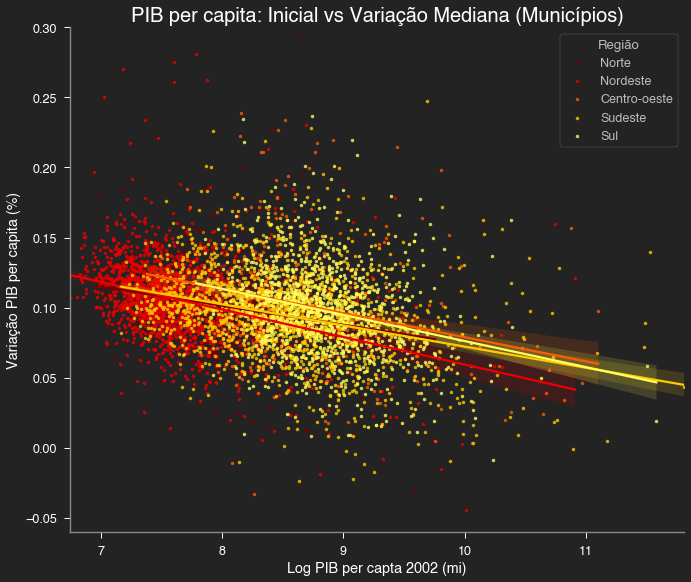

In [19]:
ax = sns.lmplot(x='PIB_Inicial',
                y='PC_capita',
                data=pib_cities.groupby(['UF','Município','Região'],as_index=False).median(),
                hue='Região',
                palette='hot',height=8,aspect=1.2,legend_out=False,scatter_kws={'s':12})
plt.xlabel('Log PIB per capta 2002 (mi)')
plt.ylabel('Variação PIB per capita (%)')
plt.ylim(-0.06,0.3)
plt.title('PIB per capita: Inicial vs Variação Mediana (Municípios)');

## 4. Análise por Cidade:
A variação proporcional (e não absoluta) permite comparar o crescimento de cidades com economias de tamanhos distintos

In [20]:
def table_plot(restricao,show_table,show_plot):
    "Funcao auxiliar das demais funcoes abaixo. Faz ajustes na tabela e plota o grafico da cidade pedida"
    "Argumentos: restrição gerada pelas outras funções"
    city=restricao[['PIB per capita','Valor adicionado','PIB','População']].pct_change().dropna()
    city.insert(0,'Ano',restricao['Ano'])
    city.insert(1,'Região',restricao['Região'])
    city.insert(2,'UF',restricao['UF'])
    city.insert(3,'Município',restricao['Município'])
#     city.insert(4,'Município',restricao['Município'])
    if show_plot==True:
        sns.lineplot(data=city,x='Ano',y='PIB per capita',label='PIB per capita')
        sns.lineplot(data=city,x='Ano',y='Valor adicionado',label='Valor adicionado')
        sns.lineplot(data=city,x='Ano',y='PIB',label='PIB')
        sns.lineplot(data=city,x='Ano',y='População',label='População')
        plt.title(restricao['Município'].values[0]+' - Crescimento Percentual do PIB')
    if show_table == True:
        return city

def pct_change_city_name_plot(regiao,uf,municipio,show_table=False,show_plot=True):
    "Retorna os ganhos percentuais de PIB per capita, Valor Adicionado e PIB para a cidade selecionada"
    "Argumentos: macrorregiao (eg. Nordeste), unidade da federação (eg. Piauí) e municipio (eg. Teresina)"
    restricao = pib_cities[(pib_cities['Região']==regiao)&(pib_cities['UF']==uf)&(pib_cities['Município']==municipio)]
    return table_plot(restricao,show_table,show_plot)

def pct_change_city_name(nome_do_municipio,show_table=False,show_plot=True):
    "Retorna os ganhos percentuais de PIB per capita, Valor Adicionado e PIB para a cidade selecionada"
    "Argumentos: codigo da cidade do IBGE (eg. Rio de Janeiro)"
    restricao = pib_cities[pib_cities['Município']==nome_do_municipio]
    return table_plot(restricao,show_table,show_plot)

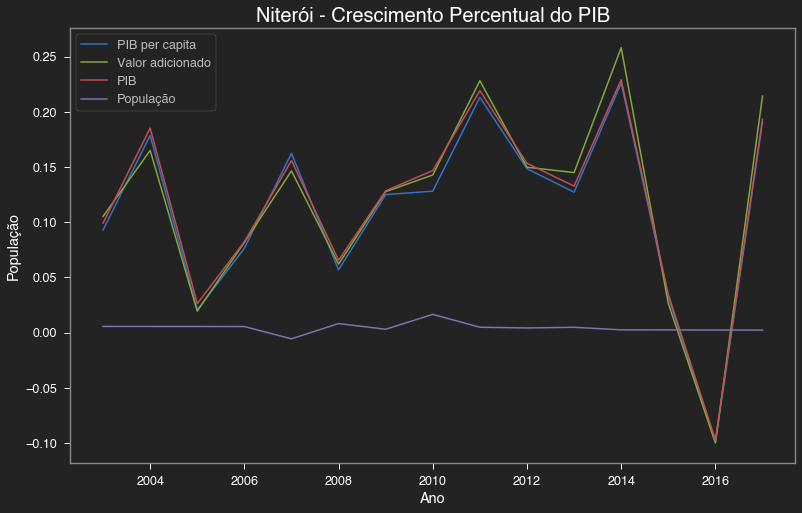

In [21]:
pct_change_city_name_plot('Sudeste', 'Rio de Janeiro', 'Niterói')

In [22]:
pct_change_city_name('Barão de Antonina',show_table=True,show_plot=False)

,Ano,Região,UF,Município,PIB per capita,Valor adicionado,PIB,População
8209,2003,Sudeste,São Paulo,Barão de Antonina,0.15,0.14,0.14,-0.01
8210,2004,Sudeste,São Paulo,Barão de Antonina,0.05,0.03,0.04,-0.01
8211,2005,Sudeste,São Paulo,Barão de Antonina,-0.09,-0.09,-0.10,-0.01
8212,2006,Sudeste,São Paulo,Barão de Antonina,0.26,0.24,0.25,-0.01
8213,2007,Sudeste,São Paulo,Barão de Antonina,-0.09,-0.04,-0.05,0.05
8214,2008,Sudeste,São Paulo,Barão de Antonina,0.12,0.14,0.15,0.03
8215,2009,Sudeste,São Paulo,Barão de Antonina,0.02,0.03,0.02,0.00
8216,2010,Sudeste,São Paulo,Barão de Antonina,0.05,0.18,0.16,0.10
8217,2011,Sudeste,São Paulo,Barão de Antonina,0.15,0.16,0.16,0.01
8218,2012,Sudeste,São Paulo,Barão de Antonina,0.12,0.12,0.13,0.01


## exercício 2

    1. Pega o pib per capta de todas as cidades no ano 2002. Calcula a variancia amostral
    2. Pega o pib per capta de todas as cidades do ano 2017. Calcula a variancia amostral
    3. Usa o teste hipoteses pra ver se a reducao (ou aumento) da variancia amostral eh estatisticamente significante
    
Supondo que a amostra é grande o suficiente para assumir para ser aproximada à normal. 


In [24]:
pib_cities_2002 = pib_cities[pib_cities['Ano'] == 2002]

pib_cities_2002.describe()

,Ano,Valor adicionado,PIB,População,PIB per capita,PC_capita,PC_adicionado,PC_PIB,PC_População,PIB_Inicial
count,5558.00,5558.00,5558.00,5558.00,5558.00,0.00,0.00,0.00,0.00,0.00
mean,2002.00,228538.08,267863.85,31.74,5302.13,nan,nan,nan,nan,nan
std,0.00,2530955.38,3075019.03,190.96,6029.05,nan,nan,nan,nan,nan
min,2002.00,2322.97,2384.28,0.81,853.31,nan,nan,nan,nan,nan
25%,2002.00,16160.70,16836.87,5.06,2155.48,nan,nan,nan,nan,nan
50%,2002.00,34479.68,36263.44,10.42,3863.47,nan,nan,nan,nan,nan
75%,2002.00,84824.44,91925.25,21.69,6462.39,nan,nan,nan,nan,nan
max,2002.00,155035187.59,188706118.97,10660.59,134623.26,nan,nan,nan,nan,nan


In [25]:
var_2002 = np.var(pib_cities_2002['PIB per capita'])

In [26]:
pib_cities_2017 = pib_cities[pib_cities['Ano'] == 2017]

pib_cities_2017.describe()

,Ano,Valor adicionado,PIB,População,PIB per capita,PC_capita,PC_adicionado,PC_PIB,PC_População,PIB_Inicial
count,5558.00,5558.00,5558.00,5558.00,5558.00,5558.00,5558.00,5558.00,5558.00,5558.00
mean,2017.00,1020109.03,1184476.25,37.36,21950.39,0.06,0.06,0.06,0.00,8.28
std,0.00,9581035.44,11634293.19,218.64,20877.31,0.19,0.19,0.20,0.01,0.73
min,2017.00,12716.17,12992.84,0.81,3285.04,-0.72,-0.73,-0.72,-0.22,6.75
25%,2017.00,75576.58,79101.86,5.51,9480.65,-0.01,-0.01,-0.00,0.00,7.68
50%,2017.00,166172.12,176621.24,11.64,16592.08,0.04,0.05,0.05,0.00,8.26
75%,2017.00,434031.37,470221.54,25.37,27045.98,0.09,0.10,0.10,0.01,8.77
max,2017.00,576762105.78,699288352.21,12106.92,344847.17,7.83,6.53,8.00,0.09,11.81


In [27]:
var_2017 = np.var(pib_cities_2017['PIB per capita'])

#### $$ H_0: \frac{\sigma_1^2}{\sigma_2^2} = 1 \ \ \ \text{X} \ \ \ H_1: \frac{\sigma_1^2}{\sigma_2^2} ≠ 1 $$

#### $$ \text{IC}: \ \ \frac{\sigma_2^2}{\sigma_1^2} = \bigg[\frac{\text{S}_2^2}{\text{S}_1^2} \ \text{F}_{\ N_2-1;\ N_1-1;\ 1-\frac{\alpha}{2}};\ \frac{\text{S}_2^2}{\text{S}_1^2} \ \text{F}_{\ N_2-1;\ N_1-1;\ \frac{\alpha}{2}} \bigg] $$

#### $$ \text{RC}: \ \ \bigg(0;\ \text{F}_{\ N_2-1;\ N_1-1;\ 1-\frac{\alpha}{2}} \bigg] \ \bigcup \ \bigg[\text{F}_{\ N_2-1;\ N_1-1;\ \frac{\alpha}{2} }; \ ∞ \bigg) $$

Usaremos um $\alpha$ de 10%

In [28]:
W = var_2002 / var_2017

df2002 = len(pib_cities_2002) - 1

df2017 = len(pib_cities_2017) - 1

W

0.08339680722932247

In [30]:
df2002 == df2017

True

In [31]:
import scipy

alpha = 0.05
p_value = scipy.stats.f.cdf(W,df2002, df2017)

print(p_value)

if p_value > alpha:
    print('Reject the null hypothesis that Var(X) == Var(Y)')

0.0


In [23]:
1 - scipy.stats.f.pdf(W,df2002, df2017)

1.0

#### $$ \implies \text{RC}: \ \ \bigg(0; \text{F}_{\ 5557;\ 5557;\ 0.95} \bigg] \ \bigcup \ \bigg[\text{F}_{\ 5557;\ 5557;\ 0.05 }; \ ∞ \bigg) $$

#### $$ \implies \text{RC}: \ \ \bigg(0;\ \frac{1}{1} \bigg] \ \bigcup \ \bigg[ 1; \ ∞ \bigg) $$

#### $$ \text{W} = 0.08339680722932259 \therefore \text{W} \in \text{RC} $$

In [24]:
1 - scipy.stats.f.cdf(alpha/2,df2002, df2017)

1.0

### Como W está dentro da Região Crítica, iremos rejeitar a hipóstese nula!

---

#### $$ \text{IC} \bigg(\frac{\sigma_2^2}{\sigma_1^2}\bigg) = \bigg[ \frac{\text{S}_2^2}{\text{S}_1^2} \ \text{F}_{\ 5557;\ 5557;\ 0.95};\ \frac{\text{S}_2^2}{\text{S}_1^2} \ \text{F}_{\ 5557;\ 5557;\ 0.05} \bigg] $$

In [25]:
W * (1 - scipy.stats.f.cdf(alpha/2,df2002, df2017))

0.08339680722932259

In [26]:
W * 1/(1 - scipy.stats.f.cdf(alpha/2,df2002, df2017))

0.08339680722932259

#### $$ \implies \text{IC} \bigg(\frac{\sigma_2^2}{\sigma_1^2}\bigg) = \bigg[ 0.08339680722932259;\ 0.08339680722932259 \bigg] $$

---

#### $$ \text{p-valor} = 0 $$

---

In [27]:
anos    = []
var_ano = []

for ano in pib_cities['Ano'].unique():
    
    anos.append(ano)
    
    var_no_ano = np.var(pib_cities[pib_cities['Ano'] == ano]['PIB per capita'])
    
    var_ano.append(var_no_ano)

df_ano_var = pd.DataFrame({'ano': anos, 'var_ano': var_ano})

df_ano_var.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
ano,2002.00,2003.00,2004.00,2005.00,2006.00,2007.00,2008.00,2009.00,2010.00,2011.00,2012.00,2013.00,2014.00,2015.00,2016.00,2017.00
var_ano,36342953.39,54346128.08,74436217.54,82102771.32,91345959.99,116432367.60,146382900.08,135480322.35,216714257.91,317237743.67,393102228.32,403287979.64,457364879.20,401093174.53,388615872.23,435783510.16


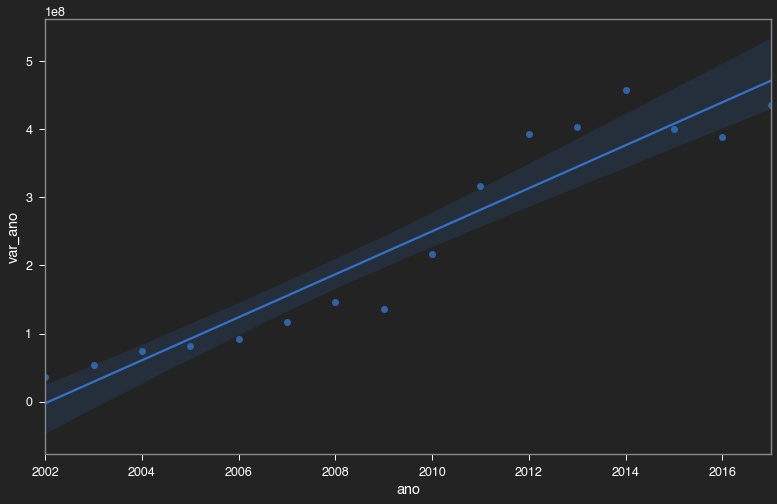

In [28]:
sns.regplot(data=df_ano_var, x="ano", y="var_ano")

---

# Questão 3

    Também é possível testar por convergência ao comparar o crescimento de duas sub-amostras de municípios: uma inicialmente mais pobre, outra inicialmente mais rica. Use um teste de médias para examinar convergência. Explicite o teste e indique o intervalo de confiança, a estatística de teste, e o valor p. Também explicite as suas decisões de como definir as sub-amostras.

---



<font color='green'>
Como podemos ver abaixo, 96% das 100 cidades mais pobres em 2002, o início da nossa amostragem, são Nordestisnas; Algo que explicita a desigualdade regional brasileira, ou em palavras de Darcy Ribeiro, existem diversos "Brasis" dentro do nosso país. Não obstante, o Norte possui 0% dentro das 100 cidades mais ricas.
    
</font> 
<br>
<br>

    


<font color='green'>
Desta forma, decidimos coletar a sub-amostra olhando para as 5 cidades mais ricas ou pobres dentro de cada região, de forma a contemplar todas as realidades desse imenso país.</font> 

In [32]:
pib_cities_2002.nlargest(100, 'PIB per capita').groupby('Região').count()[['Município']].T

Região,Centro-oeste,Nordeste,Sudeste,Sul
Município,20,7,55,18


In [33]:
pib_cities_2002.nsmallest(100, 'PIB per capita').groupby('Região').count()[['Município']].T

Região,Nordeste,Norte
Município,96,4


In [34]:
df_ricas = pd.DataFrame(columns=['Município', 'UF'])

for regiao_ in pib_cities_2002['Região'].unique():

    temp__ = pib_cities_2002[pib_cities_2002['Região'] == regiao_]
    temp__ = temp__[temp__['Município'] != 'Guamaré']         # http://www.tribunadonorte.com.br/noticia/pib-potiguar-se-concentra-em-tra-s-munica-pios/333514
    temp__ = temp__.nlargest(20, 'PIB per capita')[['Município', 'UF', 'PIB per capita']]
    
    df_ricas = df_ricas.append(temp__)
    
df_ricas.columns = ['Município', 'UF', 'PIB per capita (2002)']

In [35]:
df_ricas = pd.merge(pib_cities,df_ricas.drop_duplicates())

In [36]:
df_pobres = pd.DataFrame(columns=['Município', 'UF'])

for regiao_ in pib_cities_2002['Região'].unique():

    temp__ = pib_cities_2002[pib_cities_2002['Região'] == regiao_]
    temp__ = temp__.nsmallest(20, 'PIB per capita')[['Município', 'UF', 'PIB per capita']]
    
    df_pobres = df_pobres.append(temp__)
    
df_pobres.columns = ['Município', 'UF', 'PIB per capita (2002)']

In [37]:
df_pobres = pd.merge(pib_cities,df_pobres.drop_duplicates())

In [38]:
df_pobres.describe()

,Ano,Valor adicionado,PIB,População,PIB per capita,PC_capita,PC_adicionado,PC_PIB,PC_População,PIB_Inicial,PIB per capita (2002)
count,1600.00,1600.00,1600.00,1600.00,1600.00,1500.00,1500.00,1500.00,1500.00,1500.00,1600.00
mean,2009.50,114182.45,122198.26,21.19,5484.35,0.14,0.13,0.13,0.00,7.40,1771.33
std,4.61,243022.78,266274.83,32.22,4218.73,0.18,0.13,0.13,0.08,0.40,703.01
min,2002.00,3941.48,4031.72,2.19,853.31,-0.57,-0.36,-0.35,-0.77,6.75,853.31
25%,2005.75,23034.52,23893.80,6.65,2594.22,0.06,0.07,0.07,-0.00,7.13,1253.96
50%,2009.50,43257.52,45013.58,10.65,4338.15,0.12,0.12,0.12,0.01,7.30,1474.64
75%,2013.25,88156.98,91167.10,19.51,6854.49,0.18,0.18,0.19,0.02,7.82,2493.82
max,2017.00,2396159.46,2609696.15,214.95,40653.91,3.88,1.90,1.88,1.92,8.04,3112.79


In [39]:
df_ricas.describe()

,Ano,Valor adicionado,PIB,População,PIB per capita,PC_capita,PC_adicionado,PC_PIB,PC_População,PIB_Inicial,PIB per capita (2002)
count,1600.00,1600.00,1600.00,1600.00,1600.00,1500.00,1500.00,1500.00,1500.00,1500.00,1600.00
mean,2009.50,3580903.87,4288156.20,88.49,58803.45,0.09,0.12,0.12,0.02,10.12,31512.72
std,4.61,13874928.11,16273319.49,316.20,51184.24,0.27,0.32,0.27,0.06,0.70,24055.46
min,2002.00,-510593.06,9828.73,1.21,3765.32,-0.80,-3.19,-0.79,-0.30,8.80,6646.64
25%,2005.75,277491.62,306596.55,6.51,24714.41,-0.05,-0.03,-0.02,0.01,9.61,14863.31
50%,2009.50,680115.08,731143.01,17.20,45049.32,0.07,0.10,0.09,0.02,10.10,24356.19
75%,2013.25,1906096.92,2316826.85,49.89,75008.03,0.20,0.23,0.22,0.03,10.57,38962.28
max,2017.00,215562327.90,244682756.47,3039.44,364529.33,2.25,5.32,2.23,0.95,11.81,134623.26


https://stackoverflow.com/questions/15984221/how-to-perform-two-sample-one-tailed-t-test-with-numpy-scipy

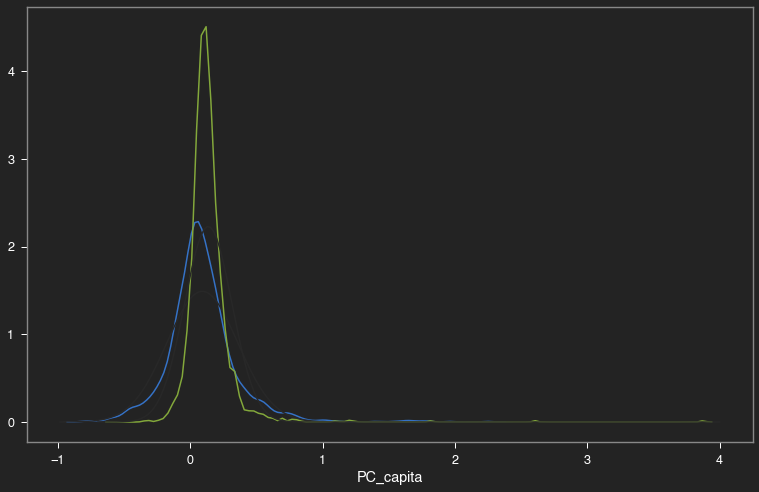

In [41]:
from scipy.stats import norm

sns.distplot(df_ricas['PC_capita'], hist=False, fit=norm)

sns.distplot(df_pobres['PC_capita'], hist=False, fit=norm);

#### $$ \text{H}_0: \mu_p - \mu_r = 0 \ \ \ \text{X} \ \ \ \text{H}_1: \mu_p - \mu_r > 0 $$

#### $$ T = \frac{ \overline{X}_p - \overline{X}_r }{ \text{S}_p \sqrt{ \frac{1}{n_p} + \frac{1}{n_r} } } $$

#### $$ S_p = \sqrt{ \frac{ (n_p - 1) s_p^2 + (n_r - 1) s_2^2 }{ n_p + n_r - 2 } } $$

#### verificar se $ T \in \text{RC} $:

#### $$ \text{RC} = \ \ \bigg[\text{t}_{\ n_p + n_r - 2;\ \alpha }; \ +∞ \bigg) $$

#### verificar se $ T \in \text{IC} $:

#### $$ \text{IC}_{100(1-\alpha)\% } (\mu_p - \mu_r) = \ \ \bigg[ (\overline{X}_p - \overline{X}_r) - \text{t}_{\ n_p + n_r - 2;\ \frac{\alpha}{2}} \text{S}_p \sqrt{ \frac{1}{n_p} + \frac{1}{n_r}  }; \ (\overline{X}_p - \overline{X}_r) + \text{t}_{\ n_p + n_r - 2;\ \frac{\alpha}{2}} \text{S}_p \sqrt{ \frac{1}{n_p} + \frac{1}{n_r}  } \bigg] $$

In [42]:
df_ricas['PC_capita'].mean()

0.09056226004595605

In [43]:
df_pobres['PC_capita'].mean()

0.13557706626498076

In [44]:
n_1 = len(df_ricas['Município'].unique())

n_2 = len(df_pobres['Município'].unique())

S_p = np.sqrt( n_1 * df_ricas['PC_capita'].var() + n_2 * df_pobres['PC_capita'].var() ) / np.sqrt( n_1 + n_2 - 2 )

T_0 = ( df_pobres['PC_capita'].mean() - df_ricas['PC_capita'].mean() ) / ( S_p * np.sqrt( 1 / n_1 + 1 / n_2 ) )

dist_t = 1.28 # scipy.stats.t.cdf(0.1, n_1 + n_2 - 2)*10

In [45]:
n_1 + n_2 - 2

198

In [46]:
scipy.stats.ttest_ind(df_pobres['PC_capita'],df_ricas['PC_capita'], nan_policy='omit')

Ttest_indResult(statistic=5.410117345011447, pvalue=6.794116375824757e-08)

In [47]:
# print('S_p \t = ', S_p)

print('T   \t = ', T_0)

print('RC  \t =  [{:.5f}; +∞)'.format(dist_t))

T   	 =  1.389884311490844
RC  	 =  [1.28000; +∞)


In [48]:
# calculate the critical value
alpha = 0.05
cv = scipy.stats.t.ppf(1.0 - 0.05, n_1 + n_2 - 2)

cv_1 = 1.645

In [49]:
p = (1 - scipy.stats.t.cdf(abs(T_0), n_1 + n_2 - 2))

In [50]:
p

0.08306233519031236

In [51]:
ic_0 = ( df_pobres['PC_capita'].mean() - df_ricas['PC_capita'].mean() ) - cv_1 * ( S_p * np.sqrt( 1 / n_1 + 1 / n_2 ) )

ic_1 = ( df_pobres['PC_capita'].mean() - df_ricas['PC_capita'].mean() ) + cv_1 * ( S_p * np.sqrt( 1 / n_1 + 1 / n_2 ) )

print('IC = [{}; {}]'.format(ic_0, ic_1))

IC = [-0.008262546160661792; 0.09829215859871121]


---

# Questão 4

    Estime uma regressão linear de crescimento municipal no período contra o PIB per capita inicial. Escolha a data de análise e o ano inicial de forma consistente com as perguntas anteriores. Reporte a estimativa para o intercepto, o coeficiente linear, e os intervalos de confiança.

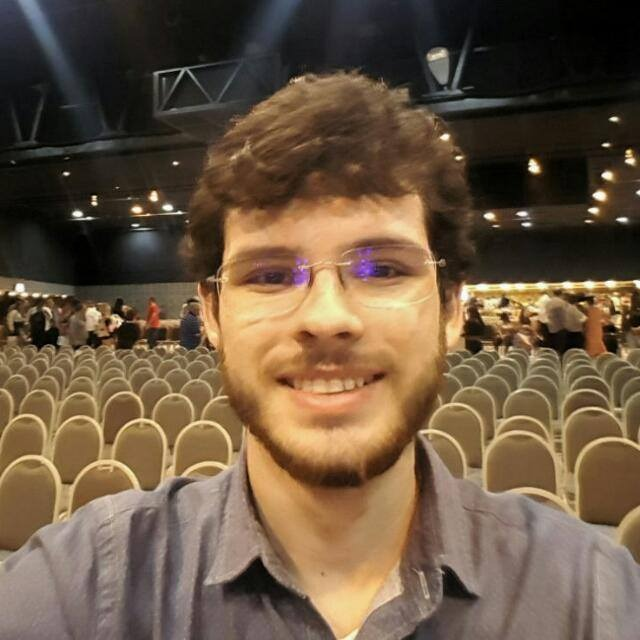

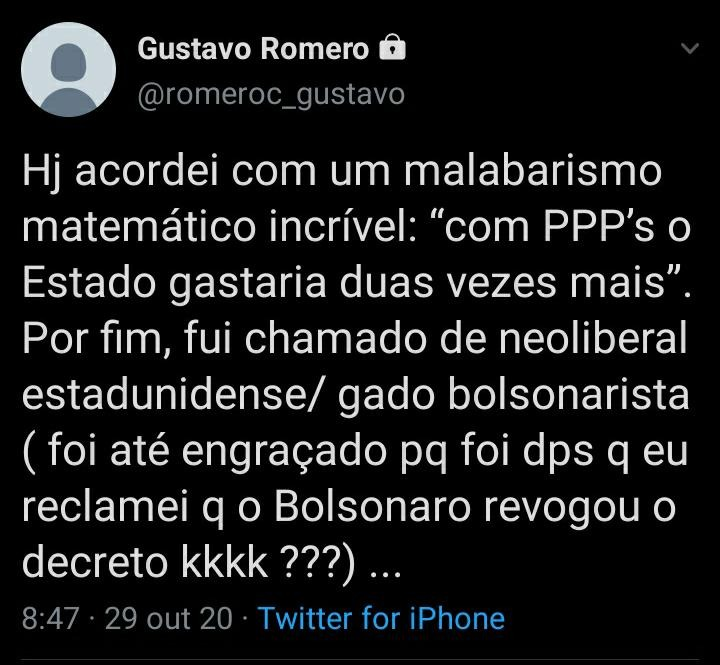

In [55]:
data = pib_cities.groupby(['UF','Município','Região'],
                          as_index=False).median()[['PIB_Inicial','PC_capita']]
data

,PIB_Inicial,PC_capita
0,8.41,0.09
1,8.15,0.11
2,8.30,0.12
3,8.28,0.09
4,8.55,0.07
...,...,...
5553,7.56,0.13
5554,8.49,0.05
5555,8.06,0.12
5556,7.96,0.08


In [56]:
X = data.drop(columns=['PC_capita'],axis=1)
y = data['PC_capita']

In [57]:
print('As colunas são:', data.columns.values,'\n')
print('A quantidade de colunas nulas é: ', data.isnull().any().sum())

As colunas são: ['PIB_Inicial' 'PC_capita'] 

A quantidade de colunas nulas é:  0


In [88]:
import statsmodels.api as sm
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PC_capita   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     523.7
Date:                Mon, 16 Nov 2020   Prob (F-statistic):          7.81e-111
Time:                        20:23:15   Log-Likelihood:                 11485.
No. Observations:                5558   AIC:                        -2.297e+04
Df Residuals:                    5556   BIC:                        -2.295e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2072      0.005     44.046      0.000       0.198       0.216
PIB_Inicial    -0.0130      0.001    -22.884      0.000      -0.014      -0.012
==============================================================================
Omnibus:                     1205.898   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9145.426
Skew:                           0.831   Prob(JB):                         0.00
Kurtosis:                       9.060   Cond. No.                         96.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
est.params

const          0.21
PIB_Inicial   -0.01
dtype: float64

$\begin{equation}
\begin{split}
\text{Variação Percentual Mediana do PIB per capta} & = \color{yellow}\alpha + \color{yellow}\beta_{\color{yellow}1}\cdot \text{PIB per capta inicial (2002)} + \color{yellow}\epsilon
\end{split}
\end{equation}$

$\begin{equation}
\begin{split}
\text{Variação Percentual Mediana do PIB per capta} & = \color{yellow}{0.21} - \color{yellow}{0.013}\cdot \text{PIB per capta inicial (2002)} + \color{yellow}\epsilon
\end{split}
\end{equation}$

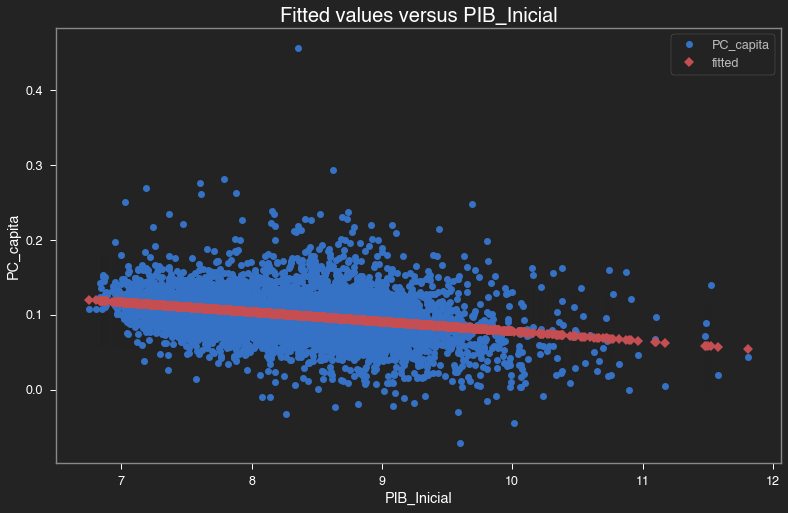

In [93]:
sm.graphics.plot_fit(est, 'PIB_Inicial');

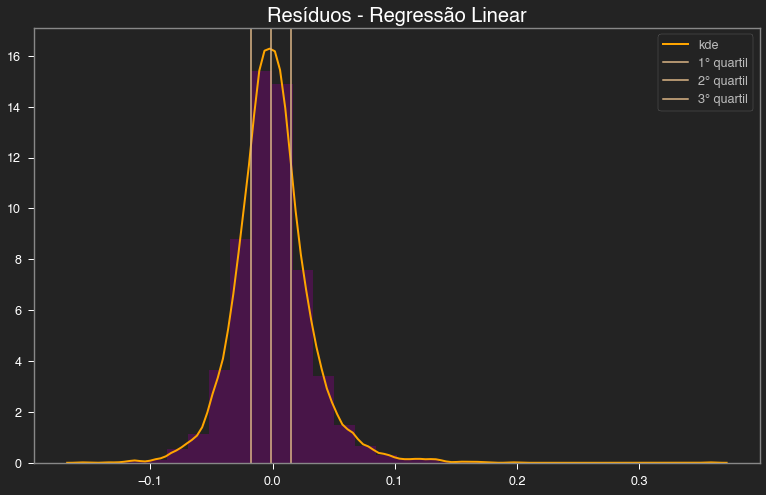

In [108]:
sns.distplot(est.resid,bins=30,color='purple',kde_kws={"color":"orange",'lw':2,'label':'kde'})
quantile = np.quantile(est.resid,[0.25,0.5,0.75])
for i in range(1,4):
    plt.axvline(x=quantile[i-1],color='burlywood',label=str(i)+'° quartil')
plt.legend()
plt.title('Resíduos - Regressão Linear');

### Testando premissas do modelo:

In [121]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(est.resid)
lzip(name, test)

[('Jarque-Bera', 9145.425644441813),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', 0.8311826456236368),
 ('Kurtosis', 9.060313889792432)]

In [123]:
from statsmodels.tsa.stattools import adfuller
resid_mean = np.mean(est.resid)
adfuller_p = adfuller(est.resid)[1]

In [125]:
print("** Mean of the residuals: ", np.around(resid_mean,2))
print("\n** Jarque Bera Normality Test, p_value:", np.around(lzip(name, test)[0][1],3), "(>0.05, Normal)" if (lzip(name, test)[0][1]>0.05) else "(<0.05, Not-normal)")
print("\n** AD Fuller, p_value:", np.around(adfuller_p,3), "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")

** Mean of the residuals:  0.0

** Jarque Bera Normality Test, p_value: 9145.426 (>0.05, Normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


In [114]:
from statsmodels.stats.stattools import durbin_watson
print('Assumption 4: No Autocorrelation', '\n')
print('Performing Durbin-Watson Test')
print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
print('0 to 2< is positive autocorrelation')
print('>2 to 4 is negative autocorrelation')
print('-------------------------------------')
durbinWatson = durbin_watson(est.resid)
print('Durbin-Watson:', durbinWatson)
if durbinWatson < 1.5:
    print('Signs of positive autocorrelation', '\n')
    print('Assumption not satisfied')
elif durbinWatson > 2.5:
    print('Signs of negative autocorrelation', '\n')
    print('Assumption not satisfied')
else:
    print('Little to no autocorrelation', '\n')
    print('Assumption satisfied')

Assumption 4: No Autocorrelation 

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.9312518971753447
Little to no autocorrelation 

Assumption satisfied
